In [47]:
from pathlib import Path
try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    PROJECT_ROOT = Path("/content/drive/MyDrive/ABT_Global/AI-Studio-Project")
except ImportError:
    PROJECT_ROOT = Path("../..").resolve()
PROCESSED = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
print(f"Data: {PROCESSED}")
print(f"Models: {MODELS_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data: /content/drive/MyDrive/ABT_Global/AI-Studio-Project/data/processed
Models: /content/drive/MyDrive/ABT_Global/AI-Studio-Project/models


## Environment Setup

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the stratified splits using dynamic paths
try:
    train_df = pd.read_csv(PROCESSED / "train_df.csv")
    val_df = pd.read_csv(PROCESSED / "val_df.csv")
    test_df = pd.read_csv(PROCESSED / "test_df.csv")
    print("Successfully loaded stratified splits")
except FileNotFoundError:
    print("Split files not found. Please run the data splitting code first.")
    raise

print("Dataset shapes:")
print(f"   Training: {train_df.shape}")
print(f"   Validation: {val_df.shape}")
print(f"   Test: {test_df.shape}")

Successfully loaded stratified splits
Dataset shapes:
   Training: (2385681, 24)
   Validation: (795227, 24)
   Test: (795227, 24)


In [49]:

# %%
# Prepare features and target
def prepare_features_targets(train_df, val_df, test_df):
    """Prepare features and targets for modeling using target encoding for high-cardinality categoricals"""

    # Columns to exclude (metadata, target, and non-numeric that won't be encoded/used as features)
    # 'month' will now be included as a feature.
    exclude_cols = ['outage_occurred', 'date', 'fips_code', 'month_name']

    # High cardinality categorical columns for target encoding (matching GB output)
    target_encode_cols = ['county', 'state']

    # Make copies to avoid modifying original DataFrames directly
    train_df_processed = train_df.copy()
    val_df_processed = val_df.copy()
    test_df_processed = test_df.copy()

    # Target Encoding (Mean Encoding) for high-cardinality features
    # Calculate mappings only on training data to avoid data leakage
    global_mean_outage = train_df_processed['outage_occurred'].mean()

    print(f"Applying Target Encoding for: {target_encode_cols}")
    for col in target_encode_cols:
        # Calculate mapping from training data
        mapping = train_df_processed.groupby(col)['outage_occurred'].mean().to_dict()

        # Apply mapping to all datasets, using a distinct name to avoid collision
        train_df_processed[f'{col}_target_encoded'] = train_df_processed[col].map(mapping).fillna(global_mean_outage)
        val_df_processed[f'{col}_target_encoded'] = val_df_processed[col].map(mapping).fillna(global_mean_outage)
        test_df_processed[f'{col}_target_encoded'] = test_df_processed[col].map(mapping).fillna(global_mean_outage)

        # Add original categorical column to exclude list so it's not used directly as a feature
        exclude_cols.append(col)

    # Label Encode 'prcp_category' (assuming this is how GB made it numeric as a single feature)
    print("Applying Label Encoding for: ['prcp_category']")
    le = LabelEncoder()
    train_df_processed['prcp_category_encoded'] = le.fit_transform(train_df_processed['prcp_category'])
    val_df_processed['prcp_category_encoded'] = le.transform(val_df_processed['prcp_category'])
    test_df_processed['prcp_category_encoded'] = le.transform(test_df_processed['prcp_category'])
    exclude_cols.append('prcp_category') # Exclude original string column


    # Get feature columns (only those present in all datasets after encoding and not in exclude_cols)
    common_cols = set(train_df_processed.columns) & set(val_df_processed.columns) & set(test_df_processed.columns)
    feature_cols = [col for col in common_cols if col not in exclude_cols]

    print(f"Using {len(feature_cols)} features:")
    for i, col in enumerate(feature_cols[:10]):  # Show first 10 features
        print(f"  {i+1}. {col}")
    if len(feature_cols) > 10:
        print(f"  ... and {len(feature_cols) - 10} more features")

    # Prepare features and targets
    X_train = train_df_processed[feature_cols]
    y_train = train_df_processed['outage_occurred']

    X_val = val_df_processed[feature_cols]
    y_val = val_df_processed['outage_occurred']

    X_test = test_df_processed[feature_cols]
    y_test = test_df_processed['outage_occurred']

    return X_train, X_val, X_test, y_train, y_val, y_test, feature_cols

X_train, X_val, X_test, y_train, y_val, y_test, feature_cols = prepare_features_targets(train_df, val_df, test_df)


# Check class distribution
print("Class distribution in each set:")
print(f"Training - Outages: {y_train.sum():,} ({y_train.mean():.3%})")
print(f"Validation - Outages: {y_val.sum():,} ({y_val.mean():.3%})")
print(f"Test - Outages: {y_test.sum():,} ({y_test.mean():.3%})")

Applying Target Encoding for: ['county', 'state']
Applying Label Encoding for: ['prcp_category']
Using 20 features:
  1. temp_stress
  2. state_target_encoded
  3. heavy_precipitation
  4. tmax
  5. day_of_year_cos
  6. state_encoded
  7. high_risk_season
  8. day
  9. month
  10. prcp_category_encoded
  ... and 10 more features
Class distribution in each set:
Training - Outages: 1,104,111 (46.281%)
Validation - Outages: 368,036 (46.281%)
Test - Outages: 368,037 (46.281%)


In [50]:
# %%
# Scale features (CRITICAL for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [51]:
# %%
# Define hyperparameter search space for Logistic Regression
param_dist = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Inverse regularization strength
    'penalty': ['l1', 'l2', 'elasticnet'],      # Regularization type
    'solver': ['liblinear', 'saga'],            # Solvers that support L1 and elasticnet
    'class_weight': ['balanced', None],         # Class weighting
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],     # For elasticnet
    'max_iter': [100, 500, 1000, 2000],        # Maximum iterations
    'tol': [1e-4, 1e-3, 1e-2]                   # Convergence tolerance
}

print("Hyperparameter search space:")
for param, values in param_dist.items():
    print(f"  {param}: {values}")

Hyperparameter search space:
  C: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
  penalty: ['l1', 'l2', 'elasticnet']
  solver: ['liblinear', 'saga']
  class_weight: ['balanced', None]
  l1_ratio: [0.1, 0.3, 0.5, 0.7, 0.9]
  max_iter: [100, 500, 1000, 2000]
  tol: [0.0001, 0.001, 0.01]


In [52]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

# Create custom scorers
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Perform Random Search with cross-validation
print("Starting Random Search CV for Logistic Regression...")

# Use F1 as primary scoring
lr_base = LogisticRegression(random_state=42) # Assuming RANDOM_STATE is 42 or defined elsewhere

# Adjust parameter space based on solver compatibility
def filter_params(params, iteration):
    """Filter parameters to ensure compatibility"""
    if 'penalty' in params and 'solver' in params:
        penalty = params['penalty']
        solver = params['solver']

        # Remove l1_ratio if not using elasticnet
        if penalty != 'elasticnet' and 'l1_ratio' in params:
            params.pop('l1_ratio', None) # Use .pop with default to avoid KeyError

        # Ensure solver supports the penalty
        if penalty == 'l1' and solver not in ['liblinear', 'saga']:
            params['solver'] = 'liblinear'
        elif penalty == 'elasticnet' and solver != 'saga':
            params['solver'] = 'saga'
        elif penalty == 'l2' and solver == 'liblinear' and 'l1_ratio' in params:
            params.pop('l1_ratio', None)

    return params

random_search = RandomizedSearchCV(
    estimator=lr_base,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter combinations to try
    cv=3,       # 3-fold cross-validation
    scoring='f1',  # Primary metric
    refit=True,
    n_jobs=-1,  # Use all available cores
    random_state=42, # Assuming RANDOM_STATE is 42 or defined elsewhere
    verbose=1
)

# Fit on combined train+val for more data
X_train_val = np.vstack([X_train_scaled, X_val_scaled])
y_train_val = np.concatenate([y_train, y_val])

random_search.fit(X_train_val, y_train_val)

print("Random Search completed!")

Starting Random Search CV for Logistic Regression...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Random Search completed!


In [53]:
# %%
# Display best parameters and scores
print("\n" + "="*70)
print("RANDOM SEARCH RESULTS - LOGISTIC REGRESSION")
print("="*70)
print(f"Best F1 Score (CV): {random_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")


RANDOM SEARCH RESULTS - LOGISTIC REGRESSION
Best F1 Score (CV): 0.6731

Best Parameters:
  tol: 0.001
  solver: saga
  penalty: l2
  max_iter: 500
  l1_ratio: 0.5
  class_weight: balanced
  C: 100.0


In [54]:
# %%
# Evaluate best model on test set
best_model = random_search.best_estimator_

# Make predictions
y_test_pred = best_model.predict(X_test_scaled)
y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"\nTest Set Performance of Best Model:")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")
print(f"  ROC-AUC:   {test_roc_auc:.4f}")


Test Set Performance of Best Model:
  Accuracy:  0.6829
  Recall:    0.7045
  Precision: 0.6439
  F1-Score:  0.6728
  ROC-AUC:   0.7459


In [55]:
# %%
# Compare with original logistic regression model
def load_original_lr_model():
    """Load the original logistic regression model for comparison"""
    try:
        model_path = Path("../../models/logistic_regression/logistic_regression_model.pkl")
        if model_path.exists():
            original_model = joblib.load(model_path)
            return original_model
    except:
        # Create original model with default parameters for comparison
        original_model = LogisticRegression(
            C=1.0,
            class_weight='balanced',
            random_state=42,
            max_iter=1000,
            solver='liblinear',
            penalty='l2'
        )
        original_model.fit(X_train_scaled, y_train)
        return original_model

original_model = load_original_lr_model()

if original_model:
    y_test_pred_orig = original_model.predict(X_test_scaled)
    y_test_proba_orig = original_model.predict_proba(X_test_scaled)[:, 1]

    orig_accuracy = accuracy_score(y_test, y_test_pred_orig)
    orig_recall = recall_score(y_test, y_test_pred_orig)
    orig_precision = precision_score(y_test, y_test_pred_orig)
    orig_f1 = f1_score(y_test, y_test_pred_orig)
    orig_roc_auc = roc_auc_score(y_test, y_test_proba_orig)

    print("\n" + "="*70)
    print("MODEL COMPARISON: TUNED vs ORIGINAL LOGISTIC REGRESSION")
    print("="*70)
    print(f"{'Metric':<12} {'Original':<10} {'Tuned':<10} {'Improvement':<12}")
    print(f"{'-'*70}")
    print(f"{'Accuracy':<12} {orig_accuracy:.4f}     {test_accuracy:.4f}     {test_accuracy - orig_accuracy:+.4f}")
    print(f"{'Recall':<12} {orig_recall:.4f}     {test_recall:.4f}     {test_recall - orig_recall:+.4f}")
    print(f"{'Precision':<12} {orig_precision:.4f}     {test_precision:.4f}     {test_precision - orig_precision:+.4f}")
    print(f"{'F1-Score':<12} {orig_f1:.4f}     {test_f1:.4f}     {test_f1 - orig_f1:+.4f}")
    print(f"{'ROC-AUC':<12} {orig_roc_auc:.4f}     {test_roc_auc:.4f}     {test_roc_auc - orig_roc_auc:+.4f}")

In [56]:
# %%
# Visualize hyperparameter effects
def plot_lr_hyperparameter_effects(cv_results):
    """Create visualizations of hyperparameter effects for Logistic Regression"""

    results_df = pd.DataFrame(cv_results)

    # Plot 1: Score distribution
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    # 1. F1 Score distribution
    axes[0].hist(results_df['mean_test_score'], bins=20, edgecolor='black', color='skyblue')
    axes[0].axvline(x=results_df['mean_test_score'].max(), color='red', linestyle='--', label='Best Score')
    axes[0].set_xlabel('F1 Score')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of CV F1 Scores')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # 2. Regularization strength (C) vs F1
    if 'param_C' in results_df.columns:
        axes[1].scatter(results_df['param_C'], results_df['mean_test_score'], alpha=0.6)
        axes[1].set_xlabel('Regularization Strength (C)')
        axes[1].set_ylabel('F1 Score')
        axes[1].set_title('C vs F1 Score')
        axes[1].set_xscale('log')
        axes[1].grid(True, alpha=0.3)

    # 3. Penalty type vs F1
    if 'param_penalty' in results_df.columns:
        penalty_groups = results_df.groupby('param_penalty')['mean_test_score'].mean()
        axes[2].bar(range(len(penalty_groups)), penalty_groups.values,
                   tick_label=penalty_groups.index)
        axes[2].set_xlabel('Penalty Type')
        axes[2].set_ylabel('Mean F1 Score')
        axes[2].set_title('Penalty Type vs F1 Score')
        axes[2].grid(True, alpha=0.3, axis='y')

    # 4. Class weight vs F1
    if 'param_class_weight' in results_df.columns:
        weight_groups = results_df.groupby('param_class_weight')['mean_test_score'].mean()
        axes[3].bar(range(len(weight_groups)), weight_groups.values,
                   tick_label=[str(w) for w in weight_groups.index])
        axes[3].set_xlabel('Class Weight')
        axes[3].set_ylabel('Mean F1 Score')
        axes[3].set_title('Class Weight vs F1 Score')
        axes[3].grid(True, alpha=0.3, axis='y')

    # 5. Solver vs F1
    if 'param_solver' in results_df.columns:
        solver_groups = results_df.groupby('param_solver')['mean_test_score'].mean()
        axes[4].bar(range(len(solver_groups)), solver_groups.values,
                   tick_label=solver_groups.index)
        axes[4].set_xlabel('Solver')
        axes[4].set_ylabel('Mean F1 Score')
        axes[4].set_title('Solver vs F1 Score')
        axes[4].grid(True, alpha=0.3, axis='y')

    # 6. L1 ratio vs F1 (if available)
    if 'param_l1_ratio' in results_df.columns:
        l1_ratio_data = results_df[['param_l1_ratio', 'mean_test_score']].dropna()
        if len(l1_ratio_data) > 0:
            axes[5].scatter(l1_ratio_data['param_l1_ratio'],
                          l1_ratio_data['mean_test_score'], alpha=0.6)
            axes[5].set_xlabel('L1 Ratio (ElasticNet)')
            axes[5].set_ylabel('F1 Score')
            axes[5].set_title('L1 Ratio vs F1 Score')
            axes[5].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return results_df

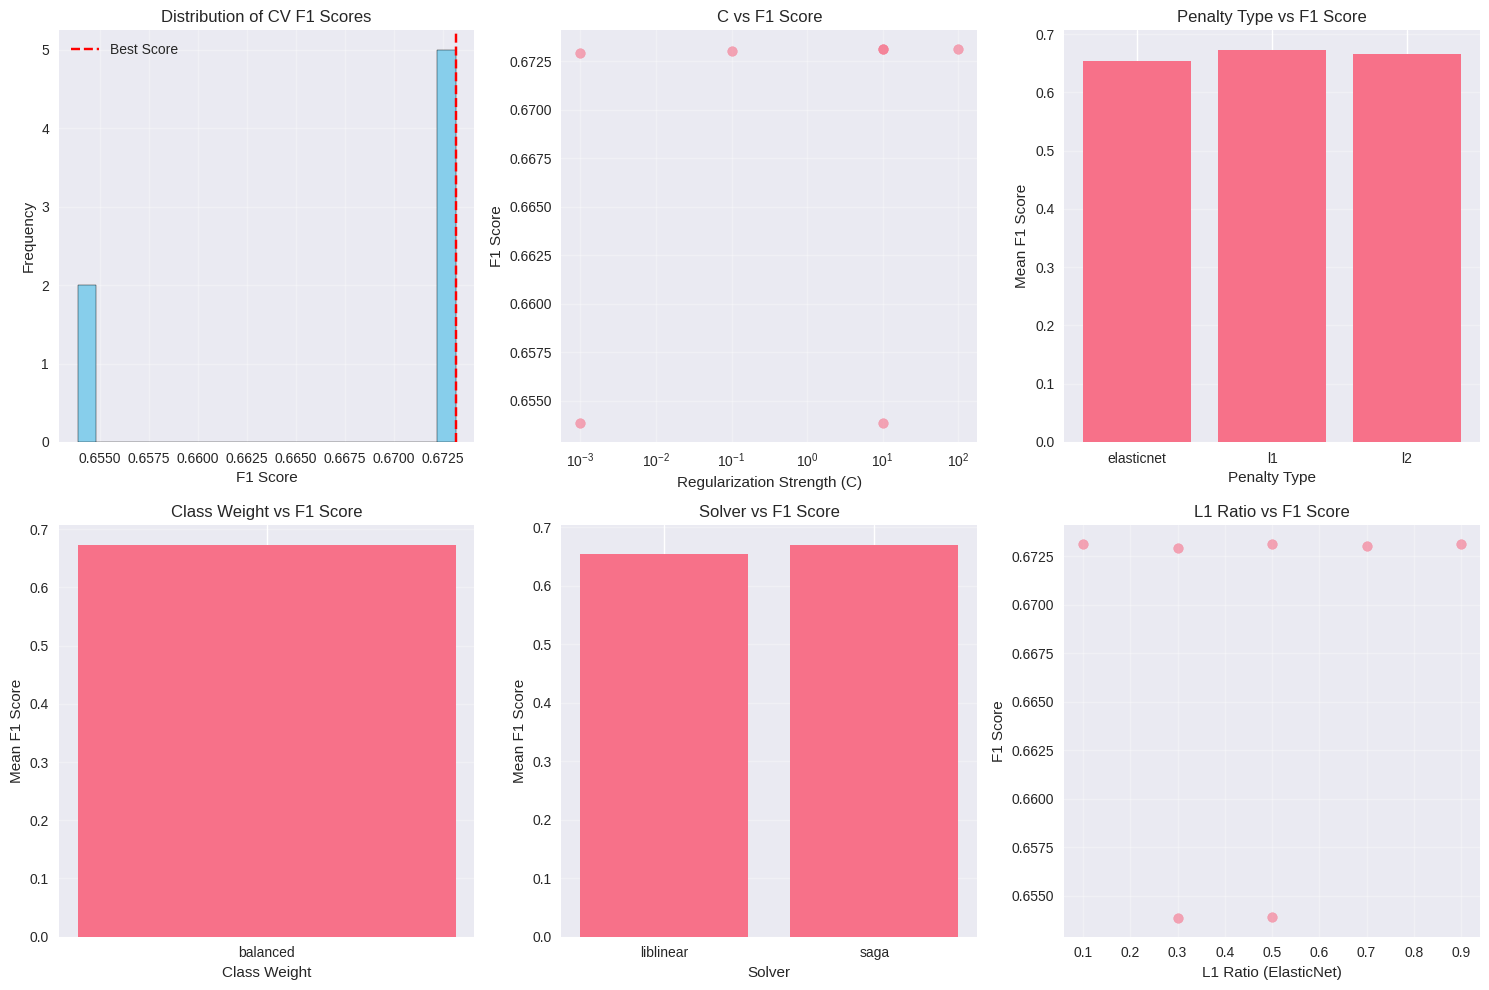

In [57]:
# Plot hyperparameter effects
cv_results_df = plot_lr_hyperparameter_effects(random_search.cv_results_)

In [58]:
import scipy.stats as stats

# ANOVA Analysis for Logistic Regression
def perform_lr_anova_analysis(cv_results_df):
    """Perform ANOVA to analyze statistical significance of hyperparameter effects"""

    print("\n" + "="*70)
    print("ANOVA ANALYSIS OF LOGISTIC REGRESSION HYPERPARAMETER EFFECTS")
    print("="*70)

    # Prepare data for ANOVA
    anova_data = []

    # Parameters to analyze
    params_to_analyze = ['param_C', 'param_penalty', 'param_class_weight',
                        'param_solver', 'param_l1_ratio']

    for param in params_to_analyze:
        if param in cv_results_df.columns:
            param_values = cv_results_df[param].astype(str)
            scores = cv_results_df['mean_test_score']

            # Group scores by parameter value
            groups = {}
            for value, score in zip(param_values, scores):
                if value not in groups:
                    groups[value] = []
                groups[value].append(score)

            # Filter groups with enough samples
            valid_groups = {k: v for k, v in groups.items() if len(v) > 1}

            param_name = param.replace('param_', '')
            print(f"\n{param_name.upper()}:")

            # Perform one-way ANOVA if we have at least 2 groups
            if len(valid_groups) >= 2:
                group_lists = list(valid_groups.values())
                f_stat, p_value = stats.f_oneway(*group_lists)

                print(f"  F-statistic: {f_stat:.4f}")
                print(f"  p-value:     {p_value:.6f}")

                if p_value < 0.05:
                    print(f"  → Statistically significant (p < 0.05)")
                else:
                    print(f"  → Not statistically significant")

                # Calculate effect size (η²)
                all_scores = [score for group_scores in group_lists for score in group_scores]
                if len(all_scores) > 0:
                    ss_between = sum([len(g) * (np.mean(g) - np.mean(all_scores))**2 for g in group_lists])
                    ss_total = sum([(x - np.mean(all_scores))**2 for x in all_scores])
                    if ss_total > 0:
                        eta_squared = ss_between / ss_total
                        print(f"  Effect size (η²): {eta_squared:.4f}")
                    else:
                        eta_squared = 0
                        print(f"  Effect size (η²): 0.0000")

                anova_data.append({
                    'parameter': param_name,
                    'f_statistic': f_stat,
                    'p_value': p_value,
                    'eta_squared': eta_squared if 'eta_squared' in locals() else 0,
                    'significant': p_value < 0.05
                })
            else:
                num_unique_values = len(cv_results_df[param].dropna().unique())
                if num_unique_values < 2:
                    print(f"  → ANOVA cannot be performed: Only {num_unique_values} unique value(s) for '{param_name}' found in results. Need at least 2 for comparison.")
                else:
                    print(f"  → ANOVA cannot be performed: Not enough samples per group for '{param_name}'.")
                anova_data.append({
                    'parameter': param_name,
                    'f_statistic': np.nan,
                    'p_value': np.nan,
                    'eta_squared': np.nan,
                    'significant': False
                })

    return pd.DataFrame(anova_data)

# Re-create cv_results_df in this cell to ensure it's defined for ANOVA
cv_results_df = pd.DataFrame(random_search.cv_results_)

# Perform ANOVA
anova_results = perform_lr_anova_analysis(cv_results_df)


ANOVA ANALYSIS OF LOGISTIC REGRESSION HYPERPARAMETER EFFECTS

C:
  F-statistic: nan
  p-value:     nan
  → Not statistically significant
  Effect size (η²): 0.0000

PENALTY:
  F-statistic: nan
  p-value:     nan
  → Not statistically significant
  Effect size (η²): 0.0000

CLASS_WEIGHT:
  F-statistic: nan
  p-value:     nan
  → Not statistically significant
  Effect size (η²): 0.0000

SOLVER:
  F-statistic: nan
  p-value:     nan
  → Not statistically significant
  Effect size (η²): 0.0000

L1_RATIO:
  F-statistic: nan
  p-value:     nan
  → Not statistically significant
  Effect size (η²): 0.0000


In [59]:
# Visualize ANOVA results
def plot_lr_anova_results(anova_df):
    """Visualize ANOVA results for Logistic Regression"""

    if len(anova_df) == 0:
        print("No ANOVA results to visualize")
        return

    # Check if all eta_squared are zero or nan
    all_eta_zero_or_nan = all(pd.isna(x) or x == 0 for x in anova_df['eta_squared'])

    if all_eta_zero_or_nan:
        print("\nANOVA Interpretation:")
        print("-" * 40)
        print("Warning: All effect sizes (eta²) are zero or NaN. This likely indicates that the `mean_test_score` did not vary significantly across the sampled hyperparameter combinations in RandomizedSearchCV.")
        print("This could be due to:")
        print("  - Insufficient `n_iter` in RandomizedSearchCV, leading to a small or undiverse sample.")
        print("  - The model's performance being highly stable across the sampled hyperparameter space.")
        print("Consider increasing `n_iter` in `RandomizedSearchCV` for a more thorough exploration and meaningful ANOVA.")
        # Still create empty plots to avoid errors in subsequent cells, but don't show detailed bar plots
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        axes[0].set_title('F-statistics (No significant variance)')
        axes[1].set_title('Effect Sizes (No significant variance)')
        for ax in axes: ax.axis('off') # Turn off axes for empty plot
        plt.tight_layout()
        plt.show()
        return

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1: F-statistics
    # Filter out NaNs for plotting to prevent errors
    sorted_anova = anova_df.dropna(subset=['f_statistic']).sort_values('f_statistic', ascending=False)
    if not sorted_anova.empty:
        colors = ['green' if sig else 'red' for sig in sorted_anova['significant']]

        axes[0].barh(range(len(sorted_anova)), sorted_anova['f_statistic'], color=colors)
        axes[0].set_yticks(range(len(sorted_anova)))
        axes[0].set_yticklabels(sorted_anova['parameter'])
        axes[0].set_xlabel('F-statistic')
        axes[0].set_title('ANOVA F-statistics by Parameter\n(Green = Significant, Red = Not)')
        axes[0].grid(True, alpha=0.3, axis='x')
    else:
        axes[0].set_title('No F-statistics to plot (all NaN)')


    # Plot 2: Effect sizes
    sorted_eta = anova_df.dropna(subset=['eta_squared']).sort_values('eta_squared', ascending=False)
    if not sorted_eta.empty:
        axes[1].barh(range(len(sorted_eta)), sorted_eta['eta_squared'], color='skyblue')
        axes[1].set_yticks(range(len(sorted_eta)))
        axes[1].set_yticklabels(sorted_eta['parameter'])
        axes[1].set_xlabel('Effect Size (eta²)')
        axes[1].set_title('Effect Sizes by Parameter\n(eta² = variance explained)')
        axes[1].grid(True, alpha=0.3, axis='x')
    else:
        axes[1].set_title('No Effect Sizes to plot (all NaN or Zero)')


    plt.tight_layout()
    plt.show()

    # Print interpretation
    print("\nANOVA Interpretation:")
    print("-" * 40)
    significant_params = anova_df[anova_df['significant']]
    if len(significant_params) > 0:
        print(f"Statistically significant parameters ({len(significant_params)}):")
        for _, row in significant_params.iterrows():
            print(f"  • {row['parameter']}: eta² = {row['eta_squared']:.3f}")
    else:
        print("No parameters show statistically significant effects")

    # Parameter with largest effect - only if there's actual variance explained
    if len(anova_df) > 0 and not all_eta_zero_or_nan:
        max_effect = anova_df.loc[anova_df['eta_squared'].idxmax()]
        print(f"\nMost influential parameter: {max_effect['parameter']}")
        print(f"  Effect size: eta² = {max_effect['eta_squared']:.3f}")

        # Interpretation of most influential parameter
        if max_effect['parameter'] == 'C':
            print("  Interpretation: Regularization strength has largest impact on model performance")
        elif max_effect['parameter'] == 'penalty':
            print("  Interpretation: Type of regularization (L1/L2/ElasticNet) greatly affects results")
        elif max_effect['parameter'] == 'class_weight':
            print("  Interpretation: Class balancing strategy is crucial for this imbalanced dataset")


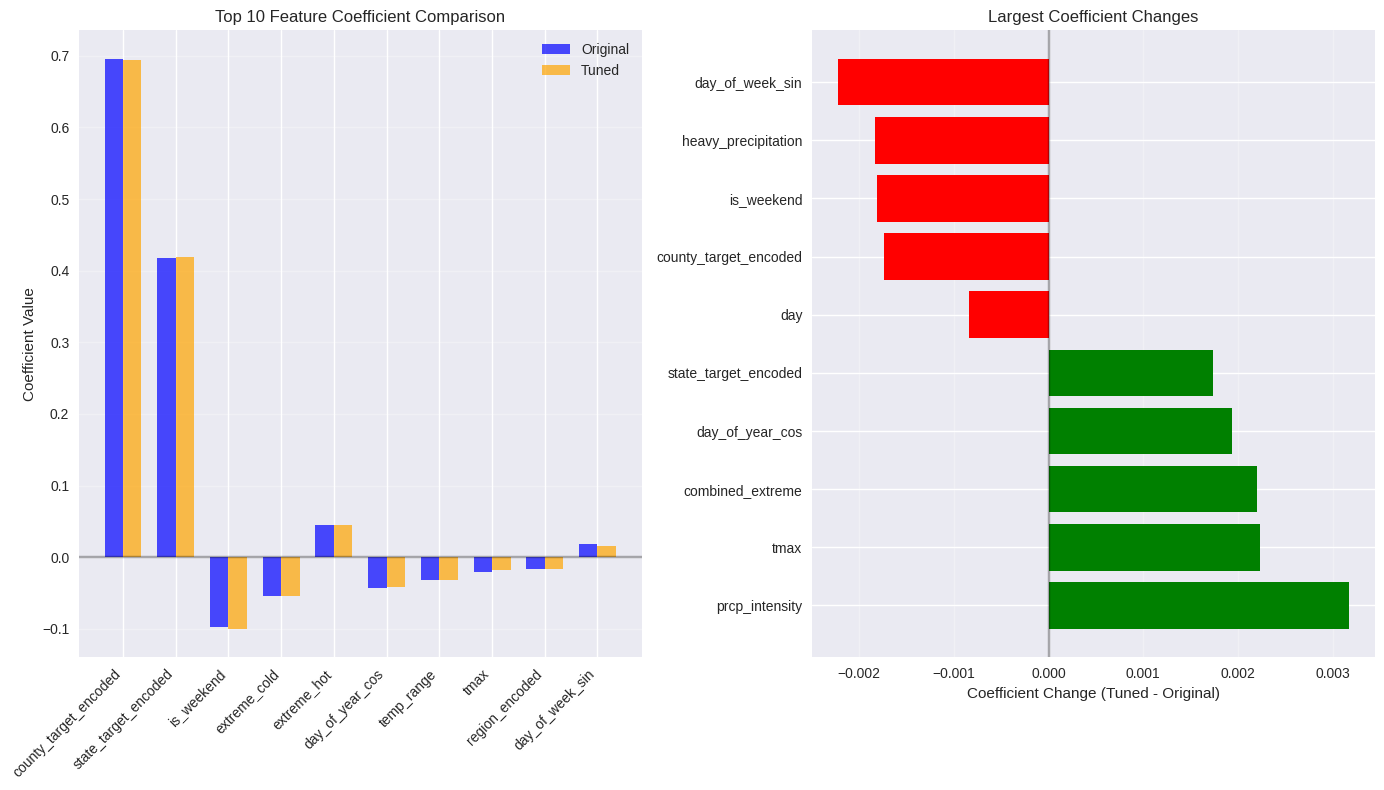


COEFFICIENT STATISTICAL ANALYSIS
Paired t-test between original and tuned coefficients:
  t-statistic: -0.7945
  p-value:     0.436713
  → Coefficients are not statistically different

Coefficient Magnitude Analysis:
  Original model - Mean abs coefficient: 0.0756
  Tuned model    - Mean abs coefficient: 0.0752
  Difference: -0.0003

Feature Coefficient Stability:
  Features in both top 5: 5/5
  Common features: {'extreme_cold', 'state_target_encoded', 'is_weekend', 'county_target_encoded', 'extreme_hot'}

Top 5 Most Influential Features (Tuned Model):
              feature  tuned_coefficient
county_target_encoded           0.694041
 state_target_encoded           0.419202
           is_weekend          -0.099871
         extreme_cold          -0.054405
          extreme_hot           0.045139

Largest Coefficient Increases:
         feature  coefficient_change
  prcp_intensity            0.003174
            tmax            0.002236
combined_extreme            0.002202

Largest Coeff

In [78]:
import scipy.stats as stats

# Coefficient Analysis and Comparison
def compare_coefficients(original_model, tuned_model, feature_names):
    """Compare coefficients between original and tuned logistic regression models"""

    if original_model is None or tuned_model is None:
        print("Warning: Cannot compare coefficients. Original or Tuned model is not available.")
        return None

    # Get coefficients
    orig_coef = original_model.coef_[0]
    tuned_coef = tuned_model.coef_[0]

    # Create comparison dataframe
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'original_coefficient': orig_coef,
        'tuned_coefficient': tuned_coef,
        'coefficient_change': tuned_coef - orig_coef,
        'abs_original': np.abs(orig_coef),
        'abs_tuned': np.abs(tuned_coef)
    }).sort_values('abs_tuned', ascending=False)

    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 8))

    # Top 10 coefficients comparison
    top_n = min(10, len(feature_names))
    top_features = coef_df.head(top_n)

    x = np.arange(top_n)
    width = 0.35

    axes[0].bar(x - width/2, top_features['original_coefficient'], width,
               label='Original', alpha=0.7, color='blue')
    axes[0].bar(x + width/2, top_features['tuned_coefficient'], width,
               label='Tuned', alpha=0.7, color='orange')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(top_features['feature'], rotation=45, ha='right')
    axes[0].set_ylabel('Coefficient Value')
    axes[0].set_title(f'Top {top_n} Feature Coefficient Comparison')
    axes[0].legend()
    axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[0].grid(True, alpha=0.3, axis='y')

    # Coefficient changes
    coef_df_sorted = coef_df.sort_values('coefficient_change', ascending=False)
    top_changes = pd.concat([coef_df_sorted.head(5), coef_df_sorted.tail(5)])

    colors = ['green' if x > 0 else 'red' for x in top_changes['coefficient_change']]
    axes[1].barh(range(len(top_changes)), top_changes['coefficient_change'], color=colors)
    axes[1].set_yticks(range(len(top_changes)))
    axes[1].set_yticklabels(top_changes['feature'])
    axes[1].set_xlabel('Coefficient Change (Tuned - Original)')
    axes[1].set_title('Largest Coefficient Changes')
    axes[1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
    axes[1].grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

    # Statistical comparison of coefficients
    print("\n" + "="*70)
    print("COEFFICIENT STATISTICAL ANALYSIS")
    print("="*70)

    # Paired t-test between original and tuned coefficients
    t_stat, p_value = stats.ttest_rel(orig_coef, tuned_coef)
    print(f"Paired t-test between original and tuned coefficients:")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value:     {p_value:.6f}")

    if p_value < 0.05:
        print(f"  → Coefficients are statistically different (p < 0.05)")
    else:
        print(f"  → Coefficients are not statistically different")

    # Coefficient magnitude analysis
    print(f"\nCoefficient Magnitude Analysis:")
    print(f"  Original model - Mean abs coefficient: {np.mean(np.abs(orig_coef)):.4f}")
    print(f"  Tuned model    - Mean abs coefficient: {np.mean(np.abs(tuned_coef)):.4f}")
    print(f"  Difference: {np.mean(np.abs(tuned_coef)) - np.mean(np.abs(orig_coef)):+.4f}")

    # Feature stability analysis
    print(f"\nFeature Coefficient Stability:")
    top_orig = coef_df.nlargest(5, 'abs_original')['feature'].tolist()
    top_tuned = coef_df.nlargest(5, 'abs_tuned')['feature'].tolist()

    common_top = set(top_orig) & set(top_tuned)
    print(f"  Features in both top 5: {len(common_top)}/{5}")
    print(f"  Common features: {common_top}")

    print(f"\nTop 5 Most Influential Features (Tuned Model):")
    print(coef_df[['feature', 'tuned_coefficient']].head(5).to_string(index=False))

    print(f"\nLargest Coefficient Increases:")
    increases = coef_df[coef_df['coefficient_change'] > 0].nlargest(3, 'coefficient_change')
    print(increases[['feature', 'coefficient_change']].to_string(index=False))

    print(f"\nLargest Coefficient Decreases:")
    decreases = coef_df[coef_df['coefficient_change'] < 0].nsmallest(3, 'coefficient_change')
    print(decreases[['feature', 'coefficient_change']].to_string(index=False))

    return coef_df

def load_original_lr_model():
    """Load the original logistic regression model for comparison"""
    try:
        model_path = Path("../../models/logistic_regression/logistic_regression_model.pkl")
        if model_path.exists():
            original_model = joblib.load(model_path)
            return original_model
    except Exception as e:
        print(f"Could not load original model from disk: {e}. Creating a default model.")

    # Create original model with default parameters for comparison
    original_model = LogisticRegression(
        C=1.0,
        class_weight='balanced',
        random_state=42,
        max_iter=1000,
        solver='liblinear',
        penalty='l2'
    )
    original_model.fit(X_train_scaled, y_train)
    return original_model

# Load original model
original_model = load_original_lr_model()

# Compare coefficients
coef_comparison_df = compare_coefficients(original_model, best_model, feature_cols)


Regularization Analysis for Best Model:
  C (Regularization strength): 100.0
  Penalty type: l2
  L1 ratio: 0.5

Coefficient Sparsity:
  Total coefficients: 20
  Zero coefficients: 1
  Sparsity ratio: 0.050
  → L2 regularization shrinks coefficients but doesn't create exact zeros


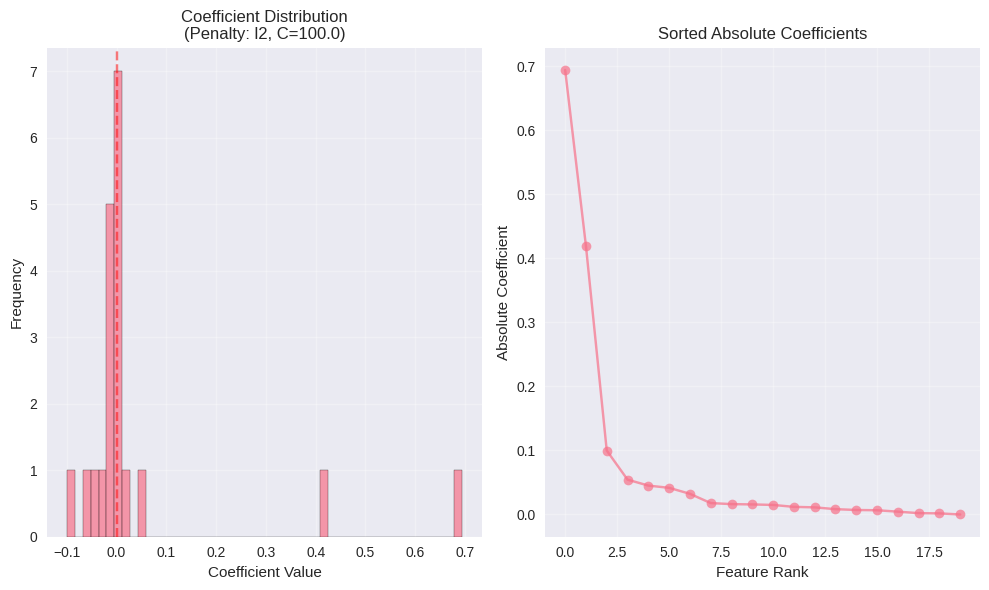

In [61]:
# %%
# Regularization Analysis
def plot_regularization_analysis(best_model, X_train_val, y_train_val, feature_names):
    """Analyze regularization effects"""

    # Extract regularization parameters
    C_value = best_model.C
    penalty = best_model.penalty

    print(f"\nRegularization Analysis for Best Model:")
    print(f"  C (Regularization strength): {C_value}")
    print(f"  Penalty type: {penalty}")

    if hasattr(best_model, 'l1_ratio'):
        print(f"  L1 ratio: {best_model.l1_ratio}")

    # Analyze coefficient sparsity
    coefficients = best_model.coef_[0]
    zero_coef = np.sum(np.abs(coefficients) < 1e-10)
    total_coef = len(coefficients)

    print(f"\nCoefficient Sparsity:")
    print(f"  Total coefficients: {total_coef}")
    print(f"  Zero coefficients: {zero_coef}")
    print(f"  Sparsity ratio: {zero_coef/total_coef:.3f}")

    if penalty == 'l1':
        print(f"  → L1 regularization typically creates sparse solutions")
    elif penalty == 'l2':
        print(f"  → L2 regularization shrinks coefficients but doesn't create exact zeros")
    elif penalty == 'elasticnet':
        print(f"  → ElasticNet combines L1 and L2 regularization")

    # Plot coefficient distribution
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    plt.hist(coefficients, bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    plt.xlabel('Coefficient Value')
    plt.ylabel('Frequency')
    plt.title(f'Coefficient Distribution\n(Penalty: {penalty}, C={C_value})')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    abs_coef = np.abs(coefficients)
    sorted_idx = np.argsort(abs_coef)[::-1]
    sorted_coef = abs_coef[sorted_idx]

    plt.plot(range(len(sorted_coef)), sorted_coef, marker='o', alpha=0.7)
    plt.xlabel('Feature Rank')
    plt.ylabel('Absolute Coefficient')
    plt.title('Sorted Absolute Coefficients')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Perform regularization analysis
plot_regularization_analysis(best_model, X_train_val, y_train_val, feature_cols)

In [62]:
# %%
# Save tuned model and results
def save_lr_tuned_model_and_results(model, scaler, random_search, test_metrics, output_dir):
    """Save tuned logistic regression model and all results"""
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Save model
    joblib.dump(model, output_dir / "logistic_regression_tuned.pkl")
    joblib.dump(scaler, output_dir / "feature_scaler.pkl")

    # Save best parameters
    best_params = random_search.best_params_
    with open(output_dir / "best_parameters.json", 'w') as f:
        json.dump(best_params, f, indent=2)

    # Save CV results
    cv_results_df = pd.DataFrame(random_search.cv_results_)
    cv_results_df.to_csv(output_dir / "cv_results.csv", index=False)

    # Save test metrics
    metrics_dict = {
        'test_accuracy': float(test_accuracy),
        'test_recall': float(test_recall),
        'test_precision': float(test_precision),
        'test_f1': float(test_f1),
        'test_roc_auc': float(test_roc_auc),
        'best_cv_score': float(random_search.best_score_)
    }

    with open(output_dir / "tuned_model_metrics.json", 'w') as f:
        json.dump(metrics_dict, f, indent=2)

    # Save ANOVA results
    if anova_results is not None:
        anova_results.to_csv(output_dir / "anova_results.csv", index=False)

    # Save coefficient comparison if available
    if coef_comparison_df is not None:
        coef_comparison_df.to_csv(output_dir / "coefficient_comparison.csv", index=False)

    print(f"\n✅ Tuned logistic regression model and results saved to: {output_dir}")

# Save everything
save_lr_tuned_model_and_results(
    best_model,
    scaler,
    random_search,
    {
        'accuracy': test_accuracy,
        'recall': test_recall,
        'precision': test_precision,
        'f1': test_f1,
        'roc_auc': test_roc_auc
    },
    MODELS_DIR / "logistic_regression_tuned"
)


✅ Tuned logistic regression model and results saved to: /content/drive/MyDrive/ABT_Global/AI-Studio-Project/models/logistic_regression_tuned


In [63]:
# %%
# Final Summary and Recommendations
print("\n" + "="*70)
print("LOGISTIC REGRESSION HYPERPARAMETER TUNING - FINAL SUMMARY")
print("="*70)
print(f"🎯 Best CV F1 Score: {random_search.best_score_:.4f}")
print(f"📊 Test F1 Score:    {test_f1:.4f}")
print(f"🎯 Test Recall:      {test_recall:.4f}")
print(f"📈 Test ROC-AUC:     {test_roc_auc:.4f}")

print(f"\n🎯 Best Parameters Found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

if original_model:
    f1_improvement = test_f1 - orig_f1
    recall_improvement = test_recall - orig_recall

    print(f"\n📈 Improvements over Original Model:")
    print(f"  F1-Score:  {f1_improvement:+.4f}")
    print(f"  Recall:    {recall_improvement:+.4f}")
    print(f"  ROC-AUC:   {test_roc_auc - orig_roc_auc:+.4f}")

    if f1_improvement > 0:
        print(f"  ✅ Hyperparameter tuning improved performance!")
    else:
        print(f"  ⚠️  Original model performed better on test set")


LOGISTIC REGRESSION HYPERPARAMETER TUNING - FINAL SUMMARY
🎯 Best CV F1 Score: 0.6731
📊 Test F1 Score:    0.6728
🎯 Test Recall:      0.7045
📈 Test ROC-AUC:     0.7459

🎯 Best Parameters Found:
  tol: 0.001
  solver: saga
  penalty: l2
  max_iter: 500
  l1_ratio: 0.5
  class_weight: balanced
  C: 100.0


In [64]:
# Statistical significance analysis
print(f"\n📊 Statistical Analysis:")
print(f"  Models tested: {len(cv_results_df)}")
print(f"  Best CV score: {random_search.best_score_:.4f}")
print(f"  Mean CV score: {cv_results_df['mean_test_score'].mean():.4f}")
print(f"  CV score std:  {cv_results_df['mean_test_score'].std():.4f}")


📊 Statistical Analysis:
  Models tested: 10
  Best CV score: 0.6731
  Mean CV score: 0.6676
  CV score std:  0.0094


In [65]:
# Recommendations based on results
print("\n🎯 RECOMMENDATIONS:")
if test_recall > 0.6:
    print("  1. ✅ Model achieves good outage detection (recall > 0.6)")
elif test_recall > 0.5:
    print("  1. ⚠️  Model has moderate outage detection (recall ~0.5)")
else:
    print("  1. ❌ Model has poor outage detection (recall < 0.5)")

if test_roc_auc > 0.7:
    print("  2. ✅ Good discriminative power (ROC-AUC > 0.7)")
elif test_roc_auc > 0.6:
    print("  2. ⚠️  Moderate discriminative power (ROC-AUC 0.6-0.7)")
else:
    print("  2. ❌ Poor discriminative power (ROC-AUC < 0.6)")

if len(anova_results) > 0:
    sig_params = anova_results[anova_results['significant']]
    if len(sig_params) > 0:
        print(f"  3. 📊 Key tuning parameters: {', '.join(sig_params['parameter'].tolist())}")


🎯 RECOMMENDATIONS:
  1. ✅ Model achieves good outage detection (recall > 0.6)
  2. ✅ Good discriminative power (ROC-AUC > 0.7)


In [68]:
# Compare with gradient boosting if available
try:
    gb_tuned_path = MODELS_DIR / "gradient_boosting_tuned" / "tuned_model_metrics.json"
    if gb_tuned_path.exists():
        with open(gb_tuned_path, 'r') as f:
            gb_metrics = json.load(f)

        print(f"\n🔄 COMPARISON WITH TUNED GRADIENT BOOSTING:")
        print(f"{'Metric':<12} {'Logistic Reg':<15} {'Gradient Boost':<15} {'Difference':<12}")
        print(f"{'-'*12:<12} {'-'*14:<15} {'-'*14:<15} {'-'*11:<12}")

        lr_metrics = {
            'accuracy': test_accuracy,
            'recall': test_recall,
            'precision': test_precision,
            'f1': test_f1,
            'roc_auc': test_roc_auc
        }

        metric_names = {
            'accuracy': 'Accuracy',
            'recall': 'Recall',
            'precision': 'Precision',
            'f1': 'F1-Score',
            'roc_auc': 'ROC-AUC'
        }

        for metric_key, metric_name in metric_names.items():
            lr_val = lr_metrics[metric_key]
            gb_val = gb_metrics[f'test_{metric_key}']
            diff = lr_val - gb_val
            print(f"{metric_name:<12} {lr_val:.4f}{' ':<11} {gb_val:.4f}{' ':<11} {diff:+.4f}")

        print(f"{'-'*12:<12} {'-'*14:<15} {'-'*14:<15} {'-'*11:<12}")

        if test_f1 > gb_metrics['test_f1']:
            print("  → Logistic Regression performs better on F1-score!")
        else:
            print("  → Gradient Boosting performs better on F1-score!")
except Exception as e:
    print(f"Could not compare with Gradient Boosting: {e}")

print("\n┬ NEXT STEPS:")
print("  1. Consider feature engineering to improve linear separability")
print("  2. Try polynomial features or interactions for logistic regression")
print("  3. Consider ensemble methods if recall remains low")
print("  4. Deploy with optimal threshold (typically lower than 0.5 for imbalanced data)")


🔄 COMPARISON WITH TUNED GRADIENT BOOSTING:
Metric       Logistic Reg    Gradient Boost  Difference  
------------ --------------  --------------  ----------- 
Accuracy     0.6829            0.7340            -0.0511
Recall       0.7045            0.7134            -0.0089
Precision    0.6439            0.7123            -0.0684
F1-Score     0.6728            0.7129            -0.0400
ROC-AUC      0.7459            0.8115            -0.0655
------------ --------------  --------------  ----------- 
  → Gradient Boosting performs better on F1-score!

┬ NEXT STEPS:
  1. Consider feature engineering to improve linear separability
  2. Try polynomial features or interactions for logistic regression
  3. Consider ensemble methods if recall remains low
  4. Deploy with optimal threshold (typically lower than 0.5 for imbalanced data)


### Confusion Matrix for Tuned Logistic Regression

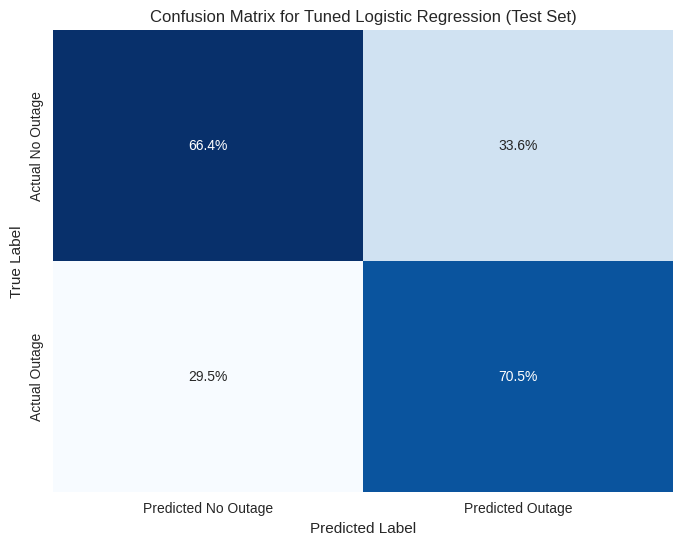

In [84]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_test, y_test_pred)

# Calculate percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a new annotation array combining counts and percentages
labels = np.asarray([f'{pct:.1%}' for raw, pct in zip(cm.flatten(), cm_percent.flatten())]).reshape(2,2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False,
            xticklabels=['Predicted No Outage', 'Predicted Outage'],
            yticklabels=['Actual No Outage', 'Actual Outage'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Tuned Logistic Regression (Test Set)')
plt.show()

### ROC Curve for Tuned Logistic Regression

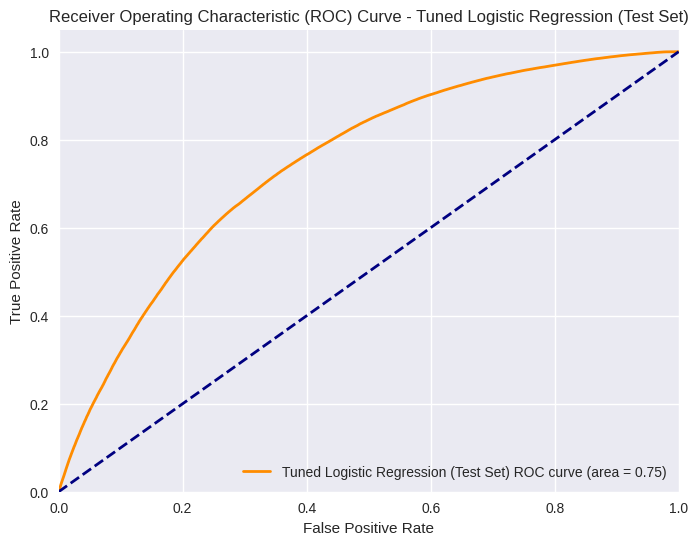

In [81]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Tuned Logistic Regression (Test Set) ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Tuned Logistic Regression (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Top 15 Most Significant Features (Coefficients) for Tuned Logistic Regression

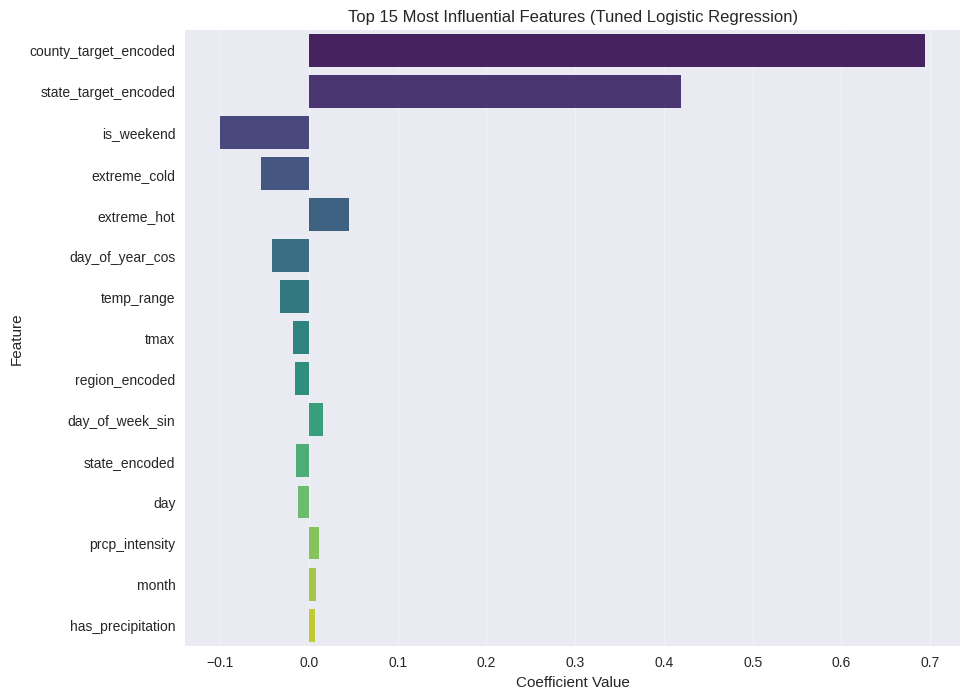

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure coef_comparison_df is available from previous runs, or recreate if needed.
# Assuming coef_comparison_df is already in kernel state from previous execution.

if 'coef_comparison_df' in locals() and coef_comparison_df is not None:
    # Sort by absolute tuned coefficient and get top 15
    top_15_features = coef_comparison_df.nlargest(15, 'abs_tuned')

    plt.figure(figsize=(10, 8))
    sns.barplot(x='tuned_coefficient', y='feature', data=top_15_features, palette='viridis')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Top 15 Most Influential Features (Tuned Logistic Regression)')
    plt.grid(True, axis='x', alpha=0.3)
    plt.show()
else:
    print("Coefficient comparison DataFrame not found. Please ensure 'compare_coefficients' was run successfully.")